In [6]:
from nutils import*
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, collections, cm
import vtk
import image_based_analysis as im

In [7]:
def SortPointsByAngle(pts_array):
    pts = pts_array.copy()
    angles = np.zeros([len(pts)])
    u = pts[0]
    u /= np.linalg.norm(u)
    u = np.array([u[0], u[1], 0])
    for i in range(len(pts)):
        v = pts[i]
        v /= np.linalg.norm(v)
        v = np.array([v[0], v[1], 0])
        s = np.sign( np.cross(u,v)[2] )
        angles[i] = s * np.arccos(np.clip(v.dot(u),-1,1))
        if s < 0:
            angles[i] += 2 * np.pi
    inds = angles.argsort()
    return inds

def BuildConnectivityArray(npts):
    connectivity = np.zeros([npts,2], dtype=int)
    for i in range(npts):
        connectivity[i] = [i, (i+1) % npts]
    return connectivity

def PlotMesh(topo, geom, f, n=5):
    sample2d = topo.sample('bezier', n)
    xvals = sample2d.eval(geom)
    fvals = sample2d.eval(f)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Mesh")
    ax.tripcolor(xvals[:,0], xvals[:,1], sample2d.tri, fvals, shading='gouraud', rasterized=True)
    sample_verts = topo.sample('bezier',2)
    verts = sample_verts.eval(geom)
    ax.add_collection(collections.LineCollection(verts[sample_verts.hull], colors='w', linewidth=0.5, alpha=1))
    return ax

In [8]:
# Read mesh
fname = "data/flow_sim.vtu"
vtk_lumen_mesh = im.ReadVTKMesh(fname)
data = {"Traction"}
lumen_mesh = im.IM_TriMesh_CreateFromVTKMesh(vtk_lumen_mesh, data)

In [9]:
# Read in Autoplaque Image Data
fname = "data/autoplaque.mha"
autoplaque_img = im.IM_Image_CreateFromVTKMetaImageFile(fname)

In [10]:
# Read in Outer wall sdf Image Data
fname = "data/outer_wall.mha"
wallsdf_img = im.IM_Image_CreateFromVTKMetaImageFile(fname)

In [11]:
# Define material properties label maps
poisson_ratio_label_map = im.IM_LabelMap({-1 : 0, 75 : 0.27, 225 : .31, 33 : 0.27, 0 : 0.4})
youngs_modulus_label_map = im.IM_LabelMap({-1 : 2 / 1000, 75 : 1000 / 1000, 225 : 10000 / 1000, 33 : 100 / 1000, 0 : 60 / 1000})

In [12]:
# Get Mesh Data
pts = lumen_mesh.verts
tractions = lumen_mesh.GetData("Traction")

In [13]:
# Define Slice
origin = (39.35025102748692, -182.88678578819045, 635.1077093084257)
normal = (0.16669412398742134, -0.9856447804529322, 0.026784991953651572)
plane = im.BuildVTKPlane(origin, normal)

In [14]:
# Slice Mesh
lumen_slice = im.SliceVTKMesh(vtk_lumen_mesh, plane)

In [15]:
# Get Slicew Data
pts = im.GetVTKMeshPoints(lumen_slice)
tractions = im.GetVTKMeshData(lumen_slice, "Traction")

In [16]:
# Transform data to local coordinates
pts_transformed = im.VTKPlaneTransformPoints(plane, pts)
tractions_transformed = im.VTKPlaneTransformVectors(plane, tractions)

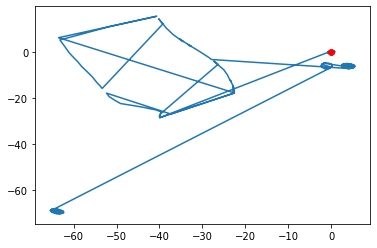

In [17]:
plt.plot(pts_transformed[:,0], pts_transformed[:,1])
plt.plot([0],[0],'ro')

In [18]:
# filter slice to isolate a single artery
filter_radius = 4
pts_filtered = np.array([pt for pt in pts_transformed if np.linalg.norm(pt) < filter_radius])
tractions_filtered = np.array([t for t, pt in zip(tractions_transformed,pts_transformed) if np.linalg.norm(pt) < filter_radius])

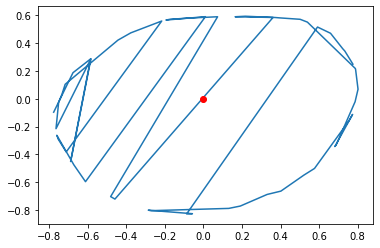

In [19]:
plt.plot(pts_filtered[:,0], pts_filtered[:,1])
plt.plot([0],[0],'ro')

In [20]:
# sort data by angle
inds = SortPointsByAngle(pts_filtered)
sorted_pts = pts_filtered[inds]
sorted_tractions = tractions_filtered[inds]

In [21]:
# create lumen slice mesh
gamma = function.Namespace()
lumen_polygon = im.IM_Polygon(sorted_pts)
gamma_topo, gamma.x = lumen_polygon.ToNutilsMesh()

In [22]:
# Create Traction Function on Lumen Mesh
gamma.linbasis = gamma_topo.basis('spline',degree=1)
gamma.tx = gamma.linbasis.dot(sorted_tractions[:,0])
gamma.ty = gamma.linbasis.dot(sorted_tractions[:,1])
gamma.traction_i = '<tx, ty>_i'

In [23]:
# create background mesh
Lf = 2
Nx = 10
Ny = 10

omega = function.Namespace()
centroid = lumen_polygon.Centroid()
diameter = lumen_polygon.EffectiveDiameter()
xmin = centroid[0] - Lf * diameter
xmax = centroid[0] + Lf * diameter
ymin = centroid[1] - Lf * diameter
ymax = centroid[1] + Lf * diameter
x = np.linspace(xmin, xmax, Nx+1)
y = np.linspace(ymin, ymax, Ny+1)
omega_topo, omega.x = mesh.rectilinear([x,y])

In [24]:
# Define Inverse Plane Transformation Function
M = im.GetVTKPlaneTransformationMatrix(plane)
print(M)
omega.M = function.asarray(M)
omega.origin = function.asarray(origin)
omega.Mx_j = 'M_ij x_i + origin_j'

[array([0.97108205, 0.16881892, 0.16881892]), array([-0.1709173 , -0.0021307 ,  0.98528307])]


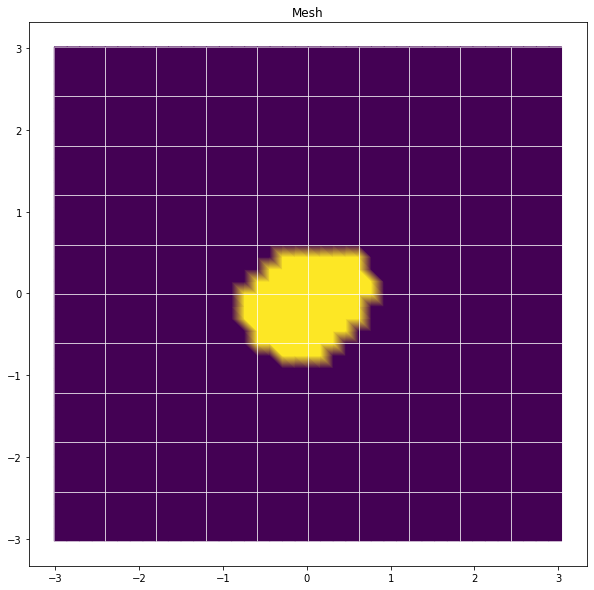

In [25]:
# Define Indicator function inside lumen slice
omega.I = im.PolygonInclusion(lumen_polygon, 1, -1, omega.x[0], omega.x[1])
PlotMesh(omega_topo, omega.x, omega.I, n=5)

In [26]:
# Test for invalid results
bez = omega_topo.sample('bezier',2)
vals = bez.eval(omega.I)
print(np.unique(vals))

[-1.  1.]


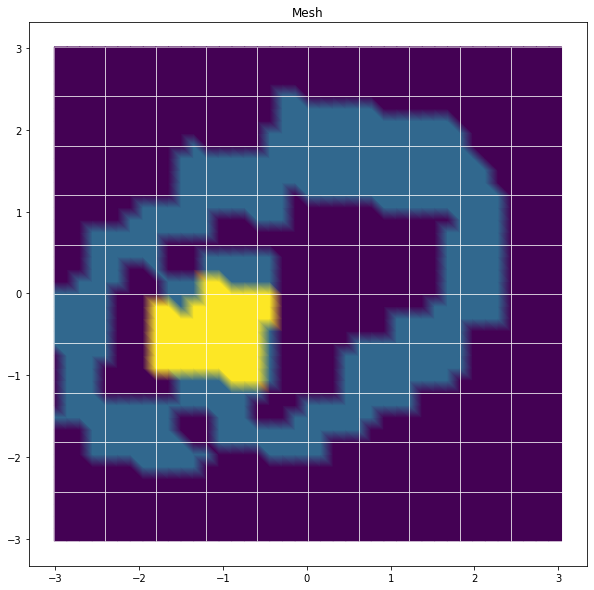

In [27]:
# Define Indicator function inside lumen slice
omega.A = im.VoxelImageFunction(autoplaque_img, omega.Mx[0], omega.Mx[1], omega.Mx[2])
PlotMesh(omega_topo, omega.x, omega.A, n=5)

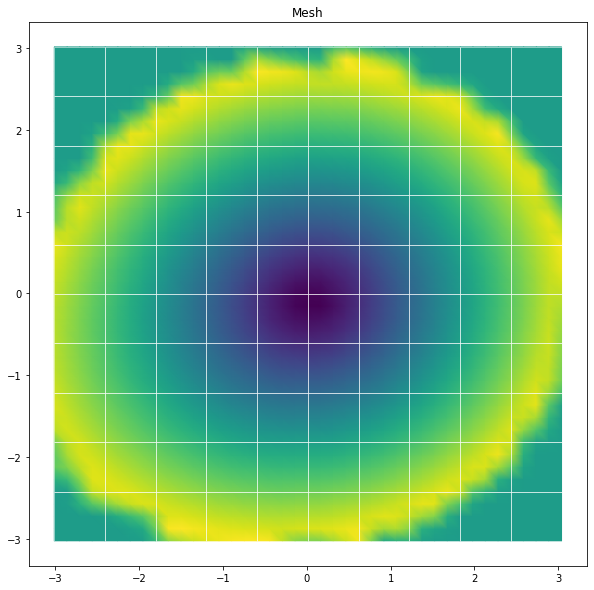

In [28]:
omega.W = im.BilinearVoxelImageFunction(wallsdf_img, omega.Mx[0], omega.Mx[1], omega.Mx[2])
PlotMesh(omega_topo, omega.x, omega.W, n=5)

In [33]:
class MaterialPropertiesLabel(function.Array):
    @types.apply_annotations
    def __init__(self, blood_label, artery_label, background_label, *args:function.asarrays):
        self.blood_label = blood_label
        self.artery_label = artery_label
        self.background_label = background_label
        shapes = set(arg.shape for arg in args)
        assert len(shapes) == 1, 'pointwise arguments have inconsistent shapes'
        shape, = shapes
        self.args = args
        super().__init__(args=args, shape=shape, dtype=float)
        
    def evalf(self, blood_indicator, wall_sdf, autoplaque):
        vals = autoplaque.copy()
        vals[np.logical_and(autoplaque==self.background_label , wall_sdf < -1e-7)] = self.artery_label
        vals[blood_indicator == 1] = self.blood_label
        return vals    
        
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)

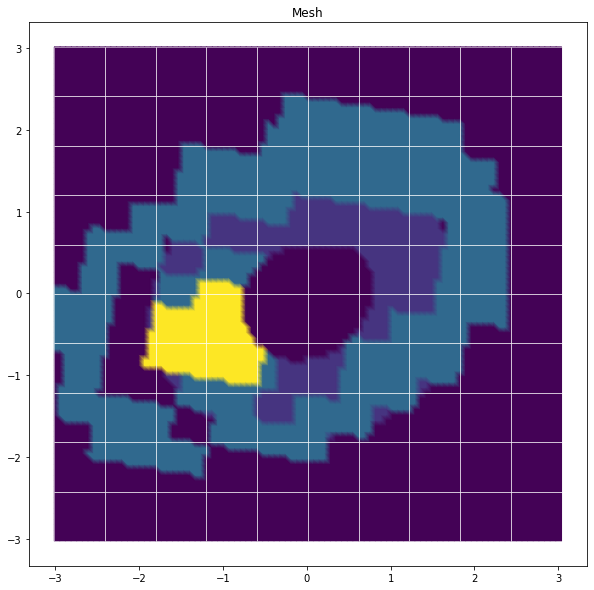

In [34]:
blood_label = -1
artery_label = 33
background_label = 0
omega.L = MaterialPropertiesLabel(blood_label, artery_label, background_label, omega.I, omega.W, omega.A)
PlotMesh(omega_topo, omega.x, omega.L, n=10)

In [35]:
bez = omega_topo.sample('bezier',2)
vals = bez.eval(omega.L)
print(np.unique(vals))
vals = autoplaque_img.GetValues()
print(np.unique(vals))


[0.0000e+00 3.3000e+01 7.5000e+01 2.2500e+02 6.5535e+04]
[  0  75 225]


In [25]:
# Define Material Properties Functions
omega.nu = im.LabelMapFunc(poisson_ratio_label_map, omega.L)
omega.E = im.LabelMapFunc(youngs_modulus_label_map, omega.L)
omega.mu = 'E / (2 (1 + nu))'
omega.lmbda = 'E nu / ( (1 + nu) (1 - 2 nu) )'

In [26]:
PlotMesh(omega_topo, omega.x, omega.E, n=5)
PlotMesh(omega_topo, omega.x, omega.nu, n=5)

EvaluationError: 
  %0 = EVALARGS
  %1 = Constant()()
  %2 = Constant(2)()
  %3 = Constant(2)()
  %4 = Constant()()
  %5 = Constant()()
  %6 = Constant()()
  %7 = Constant()()
  %8 = Constant()()
  %9 = Constant(2)()
  %10 = Tuple()
  %11 = Constant()()
  %12 = Constant(2)()
  %13 = Constant(2)()
  %14 = Constant()()
  %15 = SelectChain(evalargs=%0)
  %16 = Points(evalargs=%0)
  %17 = PopHead(trans=%15)
  %18 = ApplyTransforms(2)(points=%16, chain=%17)
  %19 = Get()(arr=%18, item=%5)
  %20 = Einsum(2)(arr1=%18, arr2=%3)
  %21 = Get()(arr=%18, item=%11)
  %22 = Einsum()(arr1=%21, arr2=%6)
  %23 = Einsum()(arr1=%19, arr2=%6)
  %24 = Add(2)(arr1=%20, arr2=%9)
  %25 = Add()(arr1=%22, arr2=%7)
  %26 = Einsum()(arr1=%12, arr2=%24)
  %27 = Einsum()(arr1=%13, arr2=%24)
  %28 = Add()(arr1=%23, arr2=%8)
  %29 = Einsum()(arr1=%2, arr2=%24)
  %30 = Add()(arr1=%29, arr2=%4)
  %31 = Add()(arr1=%27, arr2=%1)
  %32 = Add()(arr1=%26, arr2=%14)
  %33 = PolygonInclusion()(x=%25, y=%28)
  %34 = VoxelImageFunction()(x=%32, y=%30, z=%31)
  %35 = BilinearVoxelImageFunction()(x=%32, y=%30, z=%31)
  %36 = MaterialPropertiesLabel()(blood_indicator=%33, wall_sdf=%35, autoplaque=%34)
  %37 = LabelMapFunc()(label=%36) --> KeyError: 65535

In [ ]:
# create signed distance field for lumen mesh
omega.D = im.PolygonClosestPoint(lumen_polygon, omega.x[0], omega.x[1])
omega.sdf = 'I D'
PlotMesh(omega_topo, omega.x, omega.D, n=5)
PlotMesh(omega_topo, omega.x, omega.sdf, n=5)

In [ ]:
# refine background topology for basis
nref = 3
p = 2
delta = diameter / 20
refined_omega_topo = im.RefineVoxelMeshBySDF(omega_topo, omega.sdf, nref, delta=delta)
omega.basis = refined_omega_topo.basis('th-spline', degree = p)

# refine background topology for quadrature rule
nqref = 3
q = 3
refined_quadrature_topo = im.RefineVoxelMeshBySDF(refined_omega_topo, omega.sdf, nqref, delta=delta)
gauss_sample = refined_quadrature_topo.sample('gauss', q)

In [ ]:
# plot refined mesh
PlotMesh(refined_omega_topo, omega.x, omega.L, n=5)

In [ ]:
# Build Immersed Boundary Quadrature Rule
qu = 20
sample_gamma = gamma_topo.sample('gauss', qu)
sample_omega = im.locatesample(sample_gamma, gamma.x, refined_omega_topo, omega.x, 1e-7)

In [ ]:
# Rebuild traction function on Omega
omega.traction = sample_omega.asfunction(sample_gamma.eval(gamma.traction))
omega.Jgamma = sample_omega.asfunction(sample_gamma.eval(function.J(gamma.x)))

optimize > constrained 88/608 dofs
optimize > optimum value 0.00e+00
solve > solving 520 dof system to machine precision using arnoldi solver
solve > solver returned with residual 4e-11


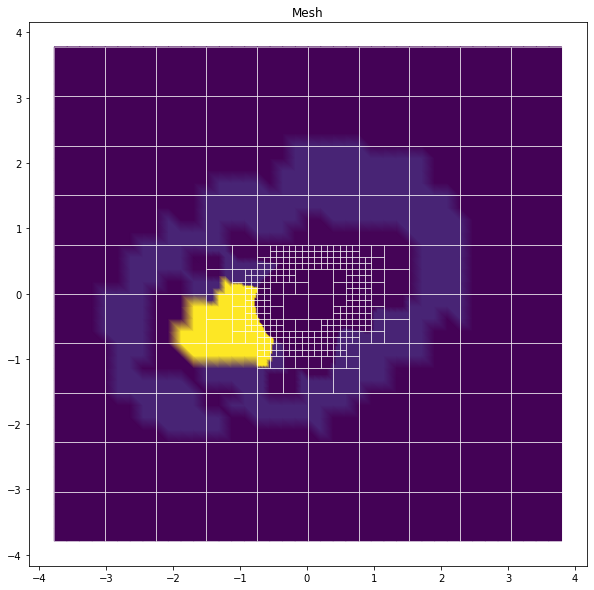

project > constrained 342/342 dofs


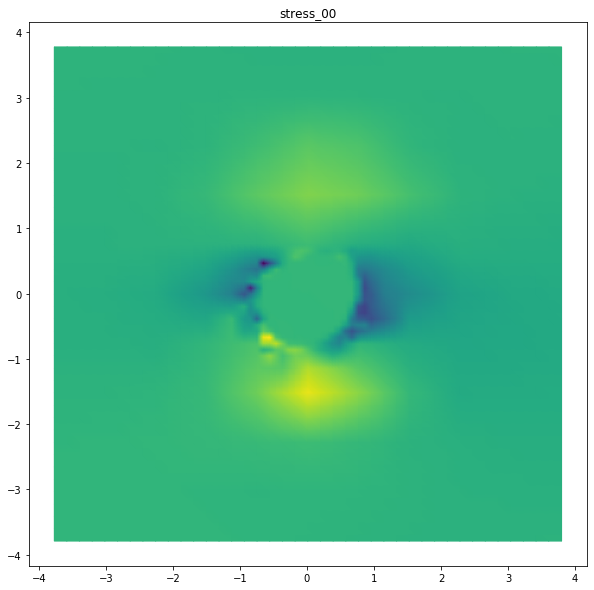

project > constrained 342/342 dofs


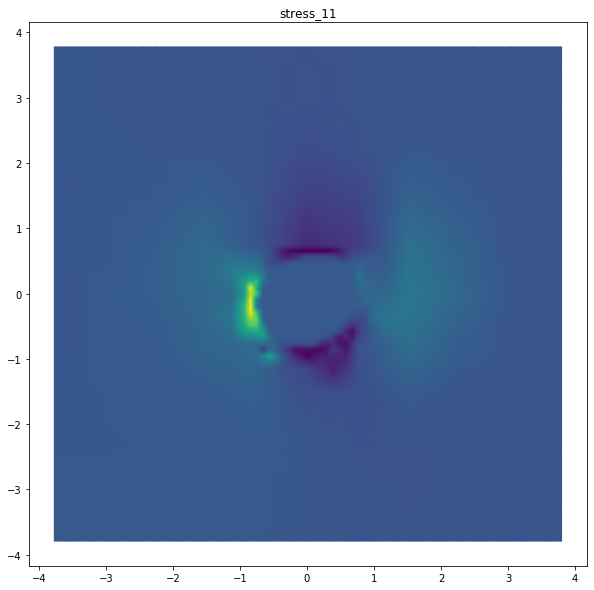

project > constrained 342/342 dofs


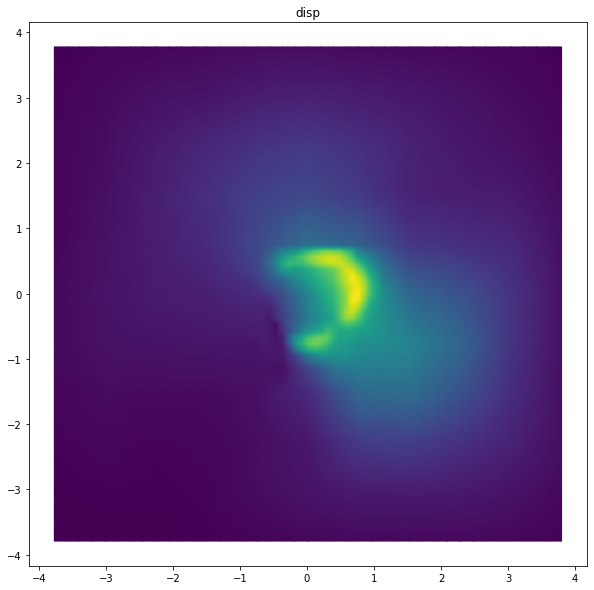

In [37]:
# define analysis
res2d = 5
p_conv = 1
vals2d = ["stress_00_smooth", "stress_11_smooth", "disp_smooth"]

omega.ubasis = omega.basis.vector(2)
omega.u_i = 'ubasis_ni ?lhs_n'
omega.X_i = 'x_i + u_i'
omega.strain_ij = '(u_i,j + u_j,i) / 2'
omega.stress_ij = 'lmbda strain_kk δ_ij + 2 mu strain_ij'
omega.meanstress = 'stress_kk / 3'
omega.S_ij = 'stress_ij - (stress_kk) δ_ij / 3'
omega.vonmises = 'sqrt(3 S_ij S_ij / 2)'
omega.disp = 'sqrt(u_i u_i)'
omega.r = 'sqrt( x_i x_i )'
omega.cos = 'x_0 / r'
omega.sin = 'x_1 / r'
omega.Qinv_ij = '< < cos , sin >_j , < -sin , cos >_j >_i'
omega.sigma_kl = 'stress_ij Qinv_kj Qinv_li '
omega.ubar_i = 'Qinv_ij u_j'
omega.eps_kl =  'strain_ij Qinv_kj Qinv_li '
omega.sigmatt = 'sigma_11'
omega.sigmarr = 'sigma_00'
omega.ur = 'ubar_0'

# Stiffness Matrix
K = gauss_sample.integral('ubasis_ni,j stress_ij d:x' @ omega)

# Force Vector
F = sample_omega.integral('traction_i Jgamma ubasis_ni' @ omega)

# Constrain Omega
sqr  = refined_omega_topo.boundary['left'].integral('u_i u_i d:x' @ omega, degree = 2*p)
sqr += refined_omega_topo.boundary['bottom'].integral('u_i u_i d:x' @ omega, degree = 2*p)
sqr += refined_omega_topo.boundary['top'].integral('u_i u_i d:x' @ omega, degree = 2*p)
sqr += refined_omega_topo.boundary['right'].integral('u_i u_i d:x' @ omega, degree = 2*p)
cons = solver.optimize('lhs', sqr, droptol=1e-15)

# Solve
lhs = solver.solve_linear('lhs', residual=K-F, constrain=cons)

# plot mesh
ax = PlotMesh(refined_omega_topo, omega.x, omega.E)
plt.show()

# Post Processing
smooth_functions = {}

#Plot 2d
sample2d = refined_omega_topo.sample('bezier', res2d)
x_vals = sample2d.eval(omega.x)
proj_basis = refined_omega_topo.basis('th-spline', degree=p_conv)
for key in vals2d:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    if "_smooth" in key:
        stripped_key = key[0:len(key)-7]
        smooth_functions[key] = refined_omega_topo.projection(stripped_key @ omega(lhs=lhs), onto=proj_basis, geometry=omega.x, ptype='convolute', ischeme='gauss{}'.format(q))
        z = sample2d.eval(smooth_functions[key])
        ax.set_title(stripped_key)
    else:
        z = sample2d.eval(key @ omega, lhs=lhs)
        z[np.logical_or( np.isnan(z) , np.isinf(z) )] = 0
        ax.set_title(key)
    ax.tripcolor(x_vals[:,0], x_vals[:,1], sample2d.tri, z, shading='gouraud', rasterized=True)
    plt.show()  
    

In [22]:
print(lumen_mesh)

In [21]:
ns = function.Namespace()

In [22]:
print(lumen_mesh)
print(autoplaque_img)

In [23]:
ap_topo, ns.x = autoplaque_img.ToNutilsMesh(shape=[5,5,5])
h = Lf * diameter
lower_bounds = origin - h * np.ones([3])
upper_bounds = origin + h * np.ones([3])
aabb = im.IM_AABB(lower_bounds, upper_bounds)
lumen_mesh.TrimByAABB(aabb)
lumen_topo, lumen_geom = lumen_mesh.ToNutilsMesh()

In [27]:
print(len(lumen_topo))
ns.Px = im.ProjectOntoTriMesh(lumen_mesh, ns.x[0], ns.x[1], ns.x[2])
ns.I = im.TriMeshInclusion()
ns.C = im.DistancePointTriMesh(lumen_mesh, ns.x[0], ns.x[1], ns.x[2])
ns.sdf = 'I C'


1820


ExpressionSyntaxError: Expected 1 index, got 0.
I C
^

In [23]:
ns.i = im.DistancePointTriMesh(lumen_mesh, ns.x[0], ns.x[1], ns.x[2])

In [27]:
bez = ap_topo.sample('gauss',1)
vals = bez.eval(ns.i)
print(vals)

[3.95208871e-01 2.51290470e-01 5.20992103e-01 3.23655787e-02
 4.46329487e-01 1.07499029e-02 8.06172588e-01 7.70173505e-02
 9.61210354e-01 7.14770418e-01 4.80193473e-01 9.72557556e-01
 2.51430976e+00 6.24780928e-02 5.40336192e-01 3.35616446e-01
 4.21278821e-01 3.22784137e-01 1.23287150e-01 4.10494138e-02
 4.86592948e-01 2.59390670e-02 8.02493489e-02 7.37769435e-02
 4.87459948e-01 6.17515655e-01 1.16082637e+00 9.95395941e-01
 3.79471838e-01 5.30656017e-01 6.96025480e-02 1.76375654e+00
 1.24297773e-01 2.70820440e-01 3.30912005e-02 6.54885996e-01
 2.94349492e-01 5.09950994e-01 1.41273786e-01 2.30251025e-01
 3.41000321e-01 1.93237740e-01 5.06622395e-02 2.33950806e-02
 2.33665899e-01 1.39527194e-01 7.43246110e-01 1.84251309e-01
 4.37191118e-02 1.97485897e-01 2.63554129e+00 7.80335841e-03
 1.57227192e-01 2.75825690e-02 3.08577491e-01 1.03436648e-01
 1.43308930e-01 3.75543791e-01 6.26124103e-01 4.04192692e-02
 1.03892755e+00 3.97880410e-02 2.39997493e-02 1.65024379e-01
 3.80333623e-02 1.248876

In [26]:
print(len(lumen_topo))

1820


In [50]:
topo, geom = mesh.rectilinear([np.linspace(0,1,10)])
bez = topo.sample(*element.parse_legacy_ischeme('vertex'))
print(np.array(bez.index))
print(bez.eval(geom).shape)

[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]]
(18, 1)


[0, 1, 0, 1]

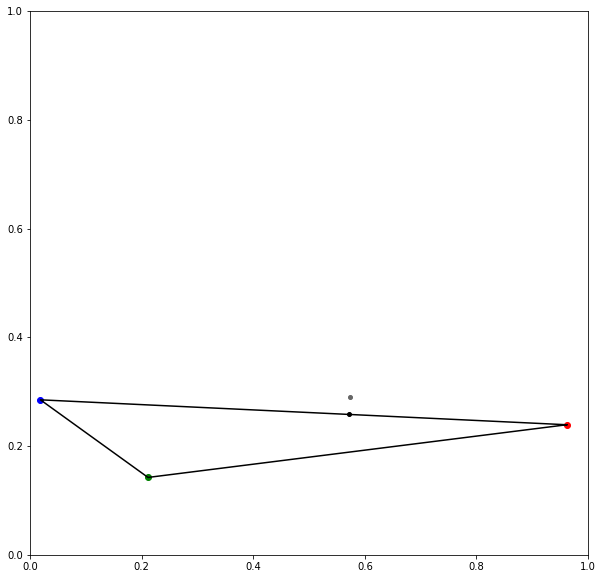

In [226]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

p1 = np.random.rand(2)
p2 = np.random.rand(2)
p3 = np.random.rand(2)

ax.plot(p1[0], p1[1], 'ro')
ax.plot(p2[0], p2[1], 'go')
ax.plot(p3[0], p3[1], 'bo')

hull = np.array([p1,p2,p3,p1])

ax.plot(hull[:,0], hull[:,1], 'k-')

npts = 1
pts = np.random.rand(npts,2)
pts = np.array([0.5 * p1 + 0.4 * p2 + 0.4 * p3])
proj = np.array([ProjectPointOntoTriangle(p, p1, p2, p3)[1] for p in pts])
ax.plot(pts[:,0], pts[:,1], 'o', color=[.4,.4,.4], markersize=4)
ax.plot(proj[:,0], proj[:,1], 'ko',markersize=4)

ax.axis([0,1,0,1])

3.7832003744119045


In [20]:
class ProjectOntoTriMesh(function.Array):
    @types.apply_annotations
    def __init__(self, tri_mesh, *args:function.asarrays):
        self.verts = tri_mesh.verts
        self.tris = tri_mesh.tris
        shape = (3,)
        super().__init__(args=args, shape=shape, dtype=np.float64)
    
    def evalf(self, x, y, z):
        return np.array([im.ProjectPointOntoTriMesh(self.verts, self.tris, np.array([xx,yy,zz])) for xx,yy,zz in zip(x,y,z)])
    
    def _derivative(self, var, seen):
        return np.zeros(self.shape + var.shape)

In [71]:
from vtk.util import numpy_support as nps
output = vtk.vtkStructuredGrid()
nx = 5
ny = 10
nz = 4
Lx = 1
Ly = 2
Lz = 0.7
origin = [0,0,0]
x = np.linspace(origin[0], origin[0] + Lx, nx)
y = np.linspace(origin[1], origin[1] + Ly, ny)
z = np.linspace(origin[2], origin[2] + Lz, nz)
ptsx, ptsy, ptsz = np.meshgrid(x,y,z, indexing='ij')
points = np.c_[ptsx.ravel('C'), ptsy.ravel('C'), ptsz.ravel('C')]
pts = vtk.vtkPoints()
pts.SetNumberOfPoints(len(points))
pts.SetData(nps.numpy_to_vtk(points))
output.SetPoints(pts)


In [77]:
writer = vtk.vtkStructuredGridWriter()
fname = "test_structured_grid.vts"
writer.SetFileName(fname)
writer.SetInputDataObject(output)
writer.Update() 

In [74]:
print(writer)

vtkStructuredGridWriter (000002859DB04DD0)
  Debug: Off
  Modified Time: 3437
  Reference Count: 1
  Registered Events: (none)
  Executive: (none)
  ErrorCode: No error
  Information: 00000285C462D810
  AbortExecute: Off
  Progress: 0
  Progress Text: (None)
  File Name: (none)
  File Type: ASCII
  Header: vtk output
  Output String Length: 0
  Output String (addr): 0000000000000000
  WriteToOutputString: Off
  Scalars Name: (None)
  Vectors Name: (None)
  Normals Name: (None)
  Tensors Name: (None)
  Texture Coordinates Name: (None)
  Global Ids Name: (None)
  Pedigree Ids Name: (None)
  Edge Flags Name: (None)
  Lookup Table Name: lookup_table
  Field Data Name: FieldData


